In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4./input_dim**2

Using TensorFlow backend.


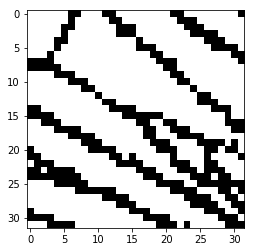

In [2]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=32
width =32
W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')
W2 = np.array(sio.loadmat('W2_Ti.mat')['W2'],dtype='float32')
W3 = np.array(sio.loadmat('W3_Ti.mat')['W3'],dtype='float32')
images = np.array(sio.loadmat('WB_test64_GAN_sm2.mat')['WB_sm'],dtype='float32')
images_style = np.array(sio.loadmat('style_img.mat')['style_img'],dtype='float32')
images[images==0]=-1
images_style[images_style==0]=-1
# images_style.shape
plt.imshow(images[0].reshape(height,width),'gray')
# plt.imshow(images_style.reshape(100,100),'gray')

In [2]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="VALID"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram #tf.nn.l2_normalize(gram,dim = 0)

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))*1000

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

mb_size = 5
z_dim = 8
X_dim = images.shape[1]
width = 32
hight = 32
h_dim = width/4*hight/4
input_dim = 32
Rad = input_dim/2

conv1_features=64
conv2_features=32
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64
num_channels_3=32
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(width, hight), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

# X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, hight, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

style_image = tf.placeholder(tf.float32, shape=(1,32,32,1))

# conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
#                                                stddev=0.1, dtype=tf.float32))
# conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) ======================================
def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob


P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))

W_conv1 = tf.reshape(tf.constant(W1),[6,6,1,24])
W_conv2 = tf.reshape(tf.constant(W2),[9,9,24,40])
W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])
# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)

combination_image=tf.reshape(X_samples[0],[1, height, width, 1])
############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])


# point correlation loss
# PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
# PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)
# PC_ran=correlation_fun(X_samples,input_dim=input_dim, Rad=Rad)

# PC_loss1=tf.abs(PC_ori-PC_rec)
# PC_loss2=tf.abs(PC_ori-PC_ran)

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss =tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))



# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)
tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl1)

solver = tf.train.AdamOptimizer().minimize(vae_loss)
solver2 = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(tot_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(30000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     _, loss, recon_E, kl_E = sess.run([solver, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    _, loss_tot, recon_E, kl_E, style_E= sess.run([solver2, tot_loss, recon_loss, kl_loss, sl1], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images[0].reshape(1,32,32,1)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E:{}'.format(style_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 4983.68847656
recon_E:269.992736816
kl_E:12.652551651
style_E:4701.04296875
()
Iter: 1000
Loss: 1578.07885742
recon_E:257.87197876
kl_E:27.5721244812
style_E:1292.63476562
()
Iter: 2000
Loss: 1563.19641113
recon_E:243.631958008
kl_E:33.3773193359
style_E:1286.18713379
()
Iter: 3000
Loss: 1521.08227539
recon_E:228.27532959
kl_E:23.8487567902
style_E:1268.95812988
()
Iter: 4000
Loss: 1522.32446289
recon_E:231.144927979
kl_E:26.5325431824
style_E:1264.64697266
()
Iter: 5000
Loss: nan
recon_E:307.724487305
kl_E:nan
style_E:2917.97094727
()
Iter: 6000
Loss: nan
recon_E:310.190490723
kl_E:nan
style_E:2913.26245117
()


KeyboardInterrupt: 

In [33]:
# conv_out1
conv_out1_test = sess.run(conv_out1,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(1,100,100,1)})
conv_out1_S_test = sess.run(conv_out1_S,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(1,100,100,1)})

In [28]:
temp=tf.nn.l2_normalize(conv_out1_test,dim = 0)
# plt.hist(conv_out1_test.reshape(-1))
(sess.run(temp)).shape

(1, 32, 32, 24)

In [29]:
def get_shape(inp):
    # returns the shape of a tensor or an array
    if type(inp) == type(np.array([])):
        return inp.shape
    else:
        return [i.value for i in inp.get_shape()]

(array([  18.,   28.,   48.,   54.,   72.,   76.,  137.,  105.,   28.,   10.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

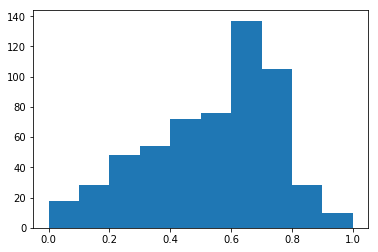

In [32]:
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
# temp_tot=(temp_tot-np.mean(temp_tot))/np.std(temp_tot)
temp_tot=(temp_tot-np.min(temp_tot.reshape(-1)))/(np.max(temp_tot.reshape(-1))-np.min(temp_tot.reshape(-1)))

plt.hist(temp_tot.reshape(-1))

(array([  24.,   38.,   54.,   70.,   88.,  103.,  107.,   67.,   21.,    4.]),
 array([ 0.10971777,  0.12818965,  0.14666154,  0.16513342,  0.1836053 ,
         0.20207719,  0.22054907,  0.23902095,  0.25749284,  0.27596472,
         0.2944366 ]),
 <a list of 10 Patch objects>)

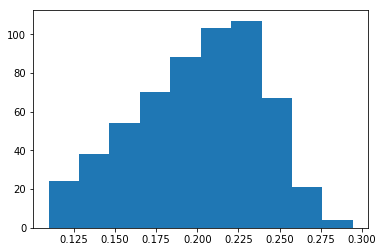

In [50]:
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
temp2=sess.run(tf.nn.l2_normalize(temp_tot,dim = 1))
plt.hist(temp2.reshape(-1))

(array([  19.,   33.,   46.,   74.,   85.,   95.,  111.,   78.,   29.,    6.]),
 array([ 0.10772207,  0.12594952,  0.14417697,  0.16240442,  0.18063188,
         0.19885933,  0.21708678,  0.23531424,  0.25354169,  0.27176914,
         0.28999659]),
 <a list of 10 Patch objects>)

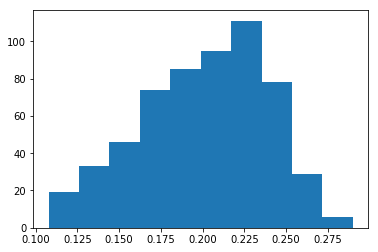

In [51]:
temp=conv_out1_S_test.reshape(-1, get_shape(conv_out1_S_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
temp2=sess.run(tf.nn.l2_normalize(temp_tot,dim = 1))
plt.hist(temp2.reshape(-1))

In [57]:
[mean, var] = tf.nn.sufficient_statistics(conv_out1_test,axes=[0])

ValueError: too many values to unpack

In [35]:
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(200000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss_tot, recon_E, kl_E, style_E= sess.run([solver2, tot_loss, recon_loss, kl_loss, sl1], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(1,100,100,1)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E:{}'.format(style_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
        
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 177.26449585
recon_E:131.921875
kl_E:23.0520858765
style_E:22.2905273438
()
Iter: 1000
Loss: 177.382247925
recon_E:126.452301025
kl_E:24.0570602417
style_E:26.8728809357
()
Iter: 2000
Loss: 165.543411255
recon_E:122.566322327
kl_E:25.2794532776
style_E:17.6976337433
()
Iter: 3000
Loss: 168.660217285
recon_E:120.859802246
kl_E:24.8084373474
style_E:22.9919815063
()
Iter: 4000
Loss: 174.114837646
recon_E:136.313323975
kl_E:25.77318573
style_E:12.0283260345
()
Iter: 5000
Loss: 169.875213623
recon_E:132.92527771
kl_E:25.7072067261
style_E:11.2427349091
()
Iter: 6000
Loss: 161.092224121
recon_E:117.441848755
kl_E:25.7792034149
style_E:17.871175766
()
Iter: 7000
Loss: 157.22769165
recon_E:114.232284546
kl_E:25.4615936279
style_E:17.5338058472
()
Iter: 8000
Loss: 156.796981812
recon_E:115.329414368
kl_E:25.38804245
style_E:16.0795249939
()
Iter: 9000
Loss: 155.748733521
recon_E:116.784591675
kl_E:25.3651065826
style_E:13.5990285873
()
Iter: 10000
Loss: 152.142105103
recon_E:110.

KeyboardInterrupt: 

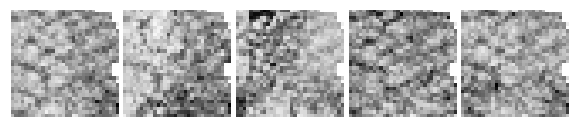

In [4]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

X_mb=images[0:5]
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(sample_temp)

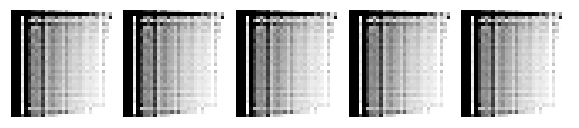

In [7]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

#     return fig
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
sample_sort=samples.reshape(-1)
# sample_sort.sort()
# samples[samples>=(np.sort(sample_sort))[300]]=1
# samples[samples<(np.sort(sample_sort))[300]]=-1
plot(samples)

In [7]:
def correlation_fun_test(xx,input_dim,Rad):
    sum_store=[]
    for ii in range(len(xx)):
        x = xx[ii]
        point_corr=0
#     if Rad <=50:
        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp1=(x[i,j]*x[i,np.mod(j+Rad,input_dim)])
                point_corr=point_corr_temp1+point_corr

        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp2=x[i,j]*x[np.mod(i+Rad,input_dim),j]
                point_corr=(point_corr_temp2+point_corr)
        sum_store.append((point_corr+2*input_dim**2)/4.)
#     print(point_corr)
    return sum_store

In [14]:
S2 = np.zeros([2*mb_size,17])
for i in range(2):
    samples=sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
    for j in range(17):
        S2[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=samples,input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([2*mb_size,17])
for i in range(2):
    for j in range(17):
        sample_ori=images[i*mb_size:(i+1)*mb_size].reshape(mb_size,32,32,1)
        S2_ori[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=sample_ori,input_dim=32,Rad=j)

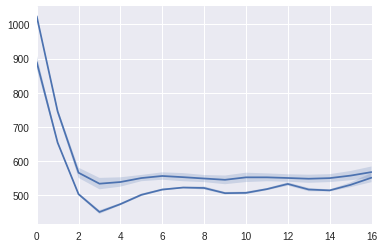

In [15]:
import seaborn as sns
%matplotlib inline
x = np.linspace(0, 16, 17)
sns.tsplot(data=S2)
sns.tsplot(data=S2_ori)

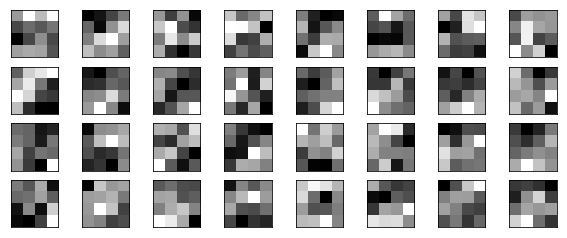

In [5]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 32  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(4, n/4, i + 1)
    plt.imshow(W3[:,:,:,i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Using TensorFlow backend.


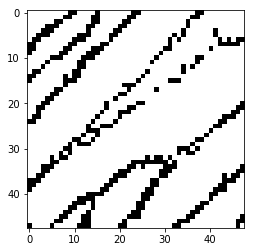

In [2]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=48
width =48
W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')
W2 = np.array(sio.loadmat('W2_Ti.mat')['W2'],dtype='float32')
W3 = np.array(sio.loadmat('W3_Ti.mat')['W3'],dtype='float32')
images = np.array(sio.loadmat('WB_test64_GAN_sm.mat')['WB_sm'],dtype='float32')
images_style = np.array(sio.loadmat('style_img.mat')['style_img'],dtype='float32')
style_img=images[3].reshape(1,height,width,1)
# images_style[images_style==0]=-1
# style_img=images_style.reshape(1,100,100,1)
plt.imshow(style_img.reshape(height,height),'gray')

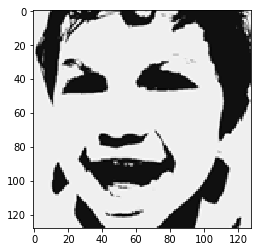

In [3]:
content_img = np.array(sio.loadmat('test_sample.mat')['sample'],dtype='float32')
content_img = content_img.reshape(1,128,128,1)
plt.imshow(content_img.reshape(128,128),'gray')
# content_img=images[3].reshape(1,height,width,1)
# plt.imshow(content_img.reshape(height,width),'gray')

In [4]:
style_image = backend.variable(style_img)
content_image = backend.variable(content_img)
combination_image = backend.placeholder((1, 128, 128, 1))

In [5]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C))*tf.square / (4. * (channels ** 2) * (size ** 2))*10000

In [6]:
import tensorflow as tf
W_conv1 = tf.reshape(tf.constant(W1),[6,6,1,24])
W_conv2 = tf.reshape(tf.constant(W2),[9,9,24,40])
W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

b_conv1 = tf.reshape(tf.constant(bias1),[-1])
b_conv2 = tf.reshape(tf.constant(bias2),[-1])

############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
# conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.sigmoid(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

# conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
# conv_out3 = tf.nn.sigmoid(conv_out3)

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
# conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.sigmoid(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

# conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
# conv_out3_S = tf.nn.sigmoid(conv_out3_S)

############# content image ############
conv_out1_C = conv2d(content_image, W_conv1, stride=1, padding='SAME')
conv_out1_C = tf.nn.sigmoid(conv_out1_C)
conv_out1_C = max_pool(conv_out1_C, k_size=2, stride=2, padding="SAME")

conv_out2_C = conv2d(conv_out1_C, W_conv2, stride=1, padding='SAME')
conv_out2_C = tf.nn.sigmoid(conv_out2_C)
conv_out2_C = max_pool(conv_out2_C, k_size=2, stride=2, padding="SAME")

NameError: name 'bias1' is not defined

In [63]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_image_features = conv_out2_C
combination_features = conv_out2

cl = content_loss(content_image_features,combination_features)*10000

In [64]:
loss = backend.variable(0.)

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])
sl2 = style_loss(conv_out2[0,:,:,:], conv_out2_S[0,:,:,:])
# sl3 = style_loss(conv_out3[0,:,:,:], conv_out3_S[0,:,:,:])

loss =  cl + sl2 + sl1

grads = backend.gradients(loss, combination_image)

In [65]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [66]:
x = np.random.uniform(-1, 1, (1, height, width, 1))

iterations = 500

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=100)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 1022011.5)
Iteration 0 completed in 0s
('Start of iteration', 1)
('Current loss value:', 705087.81)
Iteration 1 completed in 0s
('Start of iteration', 2)
('Current loss value:', 551713.5)
Iteration 2 completed in 0s
('Start of iteration', 3)
('Current loss value:', 424961.59)
Iteration 3 completed in 0s
('Start of iteration', 4)
('Current loss value:', 359430.47)
Iteration 4 completed in 0s
('Start of iteration', 5)
('Current loss value:', 314690.28)
Iteration 5 completed in 0s
('Start of iteration', 6)
('Current loss value:', 281753.44)
Iteration 6 completed in 0s
('Start of iteration', 7)
('Current loss value:', 258241.16)
Iteration 7 completed in 0s
('Start of iteration', 8)
('Current loss value:', 245174.42)
Iteration 8 completed in 0s
('Start of iteration', 9)
('Current loss value:', 234317.16)
Iteration 9 completed in 0s
('Start of iteration', 10)
('Current loss value:', 222861.69)
Iteration 10 completed in 0s
('Start of iteration

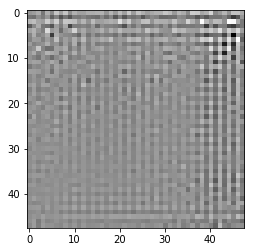

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
x = x.reshape((height, width, 1))
plt.imshow(x.reshape(48,48),'gray')

In [59]:
x, min_val, info = fmin_l_bfgs_b(conv_out1_S, x.flatten(),fprime=evaluator.grads, maxfun=100)

TypeError: 'Tensor' object is not callable